In [23]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (8.25, 6)

<h1>Thunderstorms in Texas with income</h1>

In [44]:
# load top 500 thunderstorms in texas from 1950 - 2018
data = pd.read_csv("texas_thunderstorm.csv", usecols=[1, 2, 3, 4, 6, 10, 11, 29, 30, 31, 32, 33])
data.info()

data = data.sample(frac=1)
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 12 columns):
CZ_NAME_STR            353 non-null object
BEGIN_LOCATION         353 non-null object
BEGIN_DATE             353 non-null object
BEGIN_TIME             353 non-null int64
MAGNITUDE              353 non-null float64
DAMAGE_PROPERTY_NUM    353 non-null int64
DAMAGE_CROPS_NUM       353 non-null int64
END_LOCATION           353 non-null object
BEGIN_LAT              353 non-null float64
BEGIN_LON              353 non-null float64
END_LAT                353 non-null float64
END_LON                353 non-null float64
dtypes: float64(5), int64(3), object(4)
memory usage: 33.2+ KB


,CZ_NAME_STR,BEGIN_LOCATION,BEGIN_DATE,BEGIN_TIME,MAGNITUDE,DAMAGE_PROPERTY_NUM,DAMAGE_CROPS_NUM,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON
172,NUECES CO.,CALALLEN,1/9/11,354,78.00,500000,0,SKUNK HILL,27.8561,-97.6341,27.8190,-97.5407
26,LUBBOCK CO.,Lubbock,3/29/93,1329,67.00,500000,0,,33.6750,-101.7980,33.6750,-101.7980
3,WHARTON CO.,,6/11/95,251,52.00,400000,10000,,29.3691,-96.1527,29.3691,-96.1527
274,CAMP CO.,PITTSBURG,6/28/11,1845,57.00,250000,0,PITTSBURG,33.0000,-94.9700,33.0000,-94.9700
205,LUBBOCK CO.,DOUD,8/24/12,2200,61.00,350000,0,HECKVILLE,33.5411,-101.9392,33.7204,-101.7059
46,CALDWELL CO.,MARTINDALE,6/2/03,1600,90.00,13000000,0,MARTINDALE,29.8800,-97.8700,29.8200,-97.7800
127,VAN ZANDT CO.,RODDY,4/26/11,1600,70.00,800000,0,VAN,32.4700,-96.0000,32.4985,-95.6082
287,SAN PATRICIO CO.,ST PAUL,5/23/17,1840,61.00,250000,700000,TAFT,28.1293,-97.5686,27.9800,-97.3308
84,CHILDRESS CO.,(CDS)CHILDRESS ARPT,7/29/09,2129,89.00,2000000,0,(CDS)CHILDRESS ARPT,34.4300,-100.3000,34.4567,-100.2866
295,HARRISON CO.,MARSHALL,5/27/98,1535,65.00,200000,0,MARSHALL,32.5300,-94.3700,32.5300,-94.3700


In [25]:
# The outcomes
thunderstorm_outcomes = data.iloc[:, [5]]

list(thunderstorm_outcomes)

['DAMAGE_PROPERTY_NUM']

In [26]:
# The predictors
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE'], axis=1)

# NOTE: for right now crops damage is included, but we may want to see both with and without including this

list(thunderstorm_predictors)

['BEGIN_TIME',
 'MAGNITUDE',
 'DAMAGE_CROPS_NUM',
 'BEGIN_LAT',
 'BEGIN_LON',
 'END_LAT',
 'END_LON']

In [27]:
texas_income_data = pd.read_csv("MACHINE_LEARNING_DATA/county_year/texas_median_county_income_all.csv")
texas_income_data.info()
texas_income_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 2 columns):
name        3302 non-null object
estimate    3301 non-null float64
dtypes: float64(1), object(1)
memory usage: 51.7+ KB


,name,estimate
0,ANDERSON CO.1990,27752.0
1,ANDREWS CO.1990,31106.0
2,ANGELINA CO.1990,31157.0
3,ARANSAS CO.1990,29087.0
4,ARCHER CO.1990,31425.0
5,ARMSTRONG CO.1990,29270.0
6,ATASCOSA CO.1990,25746.0
7,AUSTIN CO.1990,31527.0
8,BAILEY CO.1990,27861.0
9,BANDERA CO.1990,31641.0


In [28]:
# Add column to input features
# 1990, 2000, 2009 forward 
def parse_date(year):
    if int(year) < 95:
        return '1990'
    elif int(year) >= 95 or int(year) < 5:
        return '2000'
    elif int(year) >= 5 and int(year) < 9:
        return '2009'
    elif int(year) >= 9:
        return '20' + year
    
thunderstorm_predictors['MEAN_INCOME'] = 100
years = [date.split('/')[-1] for date in data['BEGIN_DATE']]
years = [parse_date(year) for year in years]
estimates = []
for i in range(len(thunderstorm_predictors)):
    keyword = data['CZ_NAME_STR'][i] + years[i]
    estimate = texas_income_data[texas_income_data['name'] == keyword].values[0][1]
    estimates.append(estimate)
thunderstorm_predictors['MEAN_INCOME'] = estimates
thunderstorm_predictors

# put azimuth in 

,BEGIN_TIME,MAGNITUDE,DAMAGE_CROPS_NUM,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,MEAN_INCOME
279,1256,70.0,0,27.9502,-97.9550,27.9479,-97.9376,29690.0
276,1845,70.0,0,30.4974,-96.4462,30.4974,-96.4462,29690.0
195,1715,69.0,0,31.7626,-95.6316,31.7626,-95.6316,29690.0
247,1943,61.0,0,33.9000,-98.5000,33.9000,-98.5000,30532.0
273,2035,78.0,0,31.4700,-94.9309,31.4700,-94.9309,31840.0
123,1450,90.0,0,29.3500,-98.8500,29.3000,-98.9500,30413.0
320,300,75.0,0,26.2189,-97.6798,26.2228,-97.5061,27110.0
321,2320,55.0,0,32.3200,-102.5500,32.3200,-102.5500,29629.0
239,1234,100.0,0,32.5000,-94.4500,32.5500,-94.3700,40754.0
266,1630,70.0,0,30.5700,-97.4200,30.5700,-97.4200,25592.0


In [29]:
def preprocess(thunderstorm_outcomes, thunderstorm_predictors):
    # Make the outcomes into a numpy array
    outcome_array = thunderstorm_outcomes.values.astype(np.float)

    # split into test and training data
    split_index = int(0.8 * len(outcome_array))
    outcome_array_train = outcome_array[:split_index, :]
    outcome_array_test = outcome_array[split_index:, :]
    print(outcome_array_train.shape)
    print('Shape of outcome array training', outcome_array_train.shape)
    print('Shape of outcome array test', outcome_array_test.shape)

    outcome_mean = np.mean(outcome_array)
    outcome_std = np.std(outcome_array)

    # normalize outcome
    outcome_array_train = (outcome_array_train - np.mean(outcome_array))/np.std(outcome_array)
    outcome_array_test = (outcome_array_test - np.mean(outcome_array))/np.std(outcome_array)

    # Make that numpy array into a torch Tensor
    outcome_Tensor_train = torch.from_numpy(outcome_array_train)
    outcome_Tensor_test = torch.from_numpy(outcome_array_test)

    # Make the predictors into a numpy array
    predictors_array = thunderstorm_predictors.values
    # NOTE: we took out any missing data values in the csv 

    # split into test and training data
    predictors_array_train = predictors_array[:split_index, :]
    predictors_array_test = predictors_array[split_index:, :]
    print('Shape of inputs array training', predictors_array_train.shape)
    print('Shape of inputs array test', predictors_array_test.shape)

    # Normalize inputs
    predictors_array_train = (predictors_array_train - np.mean(predictors_array, axis=0))/np.std(predictors_array, axis=0)
    predictors_array_test = (predictors_array_test - np.mean(predictors_array, axis=0))/np.std(predictors_array, axis=0)

    # Make that numpy array into a torch Tensor
    predictors_Tensor_train = torch.from_numpy(predictors_array_train.astype(np.float))
    predictors_Tensor_test = torch.from_numpy(predictors_array_test.astype(np.float))

    # Convert those DoubleTensors to FloatTensors
    # Chaning outcomes from a DoubleTensor to a FloatTensor
    outcome_Tensor_train = outcome_Tensor_train.float()
    outcome_Tensor_test = outcome_Tensor_test.float()

    # Changing the predictors too
    predictors_Tensor_train = predictors_Tensor_train.float()
    predictors_Tensor_test = predictors_Tensor_test.float()
    
    return (predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,
            outcome_Tensor_test, outcome_mean, outcome_std)

(predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)

(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)


<h1>One hidden layer</h1>

In [30]:
class one_hidden_Net(torch.nn.Module):
    def __init__(self):
        super(one_hidden_Net, self).__init__()
        self.fc1 = torch.nn.Linear(8, 5)
        self.fc2 = torch.nn.Linear(5, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)
    
# Make it
one_hidden_model = one_hidden_Net()

In [31]:
# Define the loss function
loss_fn = torch.nn.MSELoss(size_average = False)

/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [32]:
def train_neural_net(model, train_outcomes, train_inputs, test_outcomes, test_inputs):
    # Make an empty list to add to for each iteration
    current_loss_value_mini = []
    
    # For the cv too
    current_test_loss_value = []
    
    # Set the optimizer
    # originally step size was 1e-2
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-2)
    
    # Train the neural network
    # 100000 iterations seems to give much better results when networks is two layers deep
    for t in range(20000):
        # Get the current mini-batch indices
        indices = torch.randperm(len(train_inputs))[0:50]
        
        # Get the current mini-batches
        predictors_mini = train_inputs[indices]
        outcome_mini = train_outcomes[indices]
        
        # Get the current predictions
        current_pred_mini = model(predictors_mini)
        test_pred = model(test_inputs)
        
        # Compute current losses and and append that to the empty list
        current_loss_mini = loss_fn(current_pred_mini, outcome_mini)
        current_loss_value_mini.append(current_loss_mini.data.item())
        
        current_test_loss = loss_fn(test_pred, test_outcomes)
        current_test_loss_value.append(current_test_loss.data.item())
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss_mini.backward()
        
        # Update model parameters
        optimizer.step()
        
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 20000))
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value_mini) / len(predictors_mini)).tolist()
    
    # For cv too
    mse_test = (np.asarray(current_test_loss_value) / len(test_inputs)).tolist()
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.plot(iterations, mse_test, "r-")
    plt.xlabel("Iteration", size = 14)
    plt.ylabel("Loss Value", size = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("How'd the Optimizing Go?", size = 16)

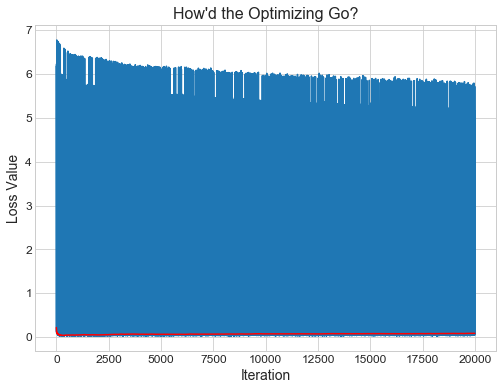

In [33]:
train_neural_net(one_hidden_model, outcome_Tensor_train, predictors_Tensor_train, 
                 outcome_Tensor_test, predictors_Tensor_test)

In [34]:
def plot_train_perf(train_predictors, train_obs, model):
    
    # Plots how well the model performs on training data
    # train_predictors = the values that the model predicts from, PyTorch Tensor
    # train_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Get the predictions
    train_predictors.requires_grad = False
    train_predictions = model(train_predictors)
    
    # Convert that to a numpy array
    train_predictions = train_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    train_predictions = (train_predictions*np.log10(outcome_std) + np.log10(outcome_mean)).tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    train_obs = (train_obs.numpy()*np.log10(outcome_std) + np.log10(outcome_mean)).tolist()
    
    
    # Plot it
    plt.scatter(train_obs, train_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    axes.set_xlim([2, 11])
    axes.set_ylim([2, 11])
#     axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.plot([2, 11], [2, 11], 'k-', lw = 2)
    axes.set_xlabel("Observed (Log-Transformed US Dollars)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars)", size = 14)
    axes.set_title("Model Performance on Training Data", size = 16)

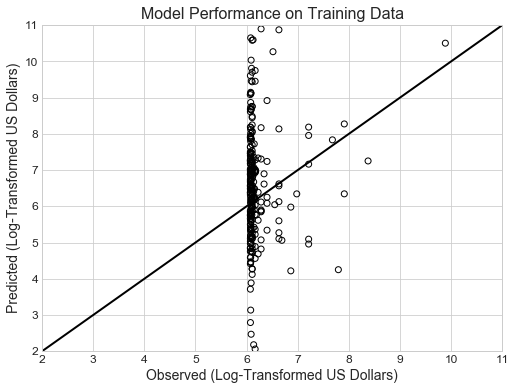

In [35]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, one_hidden_model)

In [36]:
def compute_MSE(predictors, observed_outcomes, model):
    
    # Computes the mean squared error of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield
    # Returns a PyTorch Variable
    
    
    # Get the validation set predictions
    predictors.requires_grad = False
    predictions = model(predictors)
    
    # Get the validation set outcomes
    outcomes = observed_outcomes
    
    # Get the loss - (total) residual sum of squares
    total_SE = loss_fn(predictions, outcomes)
    
    # Average that to get mean square error
    mean_SE = total_SE / len(predictors)
    return(mean_SE)

In [37]:
MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, one_hidden_model)
MSE

tensor(0.0854, grad_fn=<DivBackward0>)

<h2>Two hidden layers</h2>

In [38]:
class two_hidden_Net(torch.nn.Module):
    def __init__(self):
        super(two_hidden_Net, self).__init__()
        self.fc1 = torch.nn.Linear(8, 5)
        self.fc2 = torch.nn.Linear(5, 3)
        self.fc3 = torch.nn.Linear(3, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)
    
# Make it
two_hidden_model = two_hidden_Net()

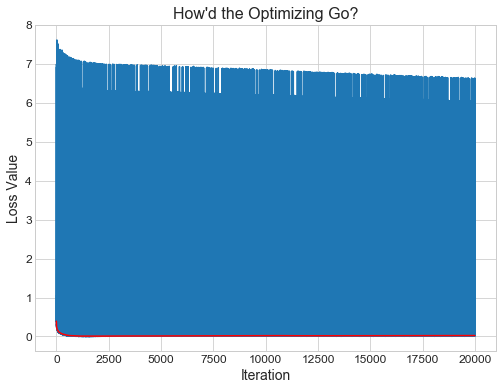

In [39]:
train_neural_net(two_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)

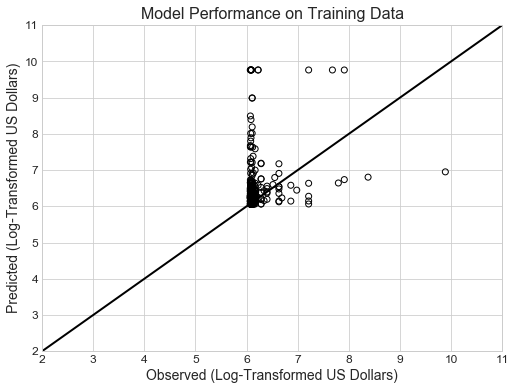

In [40]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, two_hidden_model)

In [41]:
MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, two_hidden_model)
MSE

tensor(0.0243, grad_fn=<DivBackward0>)

(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array tr

(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 8)
Shape of inputs array test (71, 8)
(282, 1)
Shape of outcome array tr

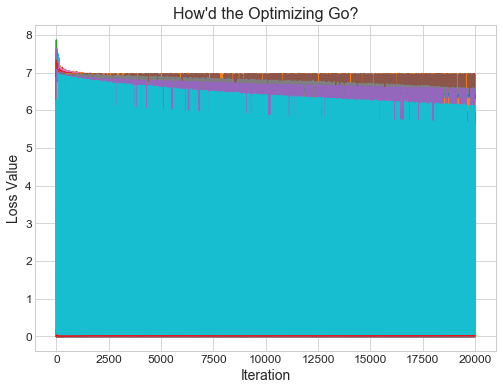

In [43]:
best_model = None
best_mse = 10
for i in range(100):
    data = data.sample(frac=1)
    thunderstorm_outcomes = data.iloc[:, [5]]
    thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE'], axis=1)
    thunderstorm_predictors['MEAN_INCOME'] = 100
    years = [date.split('/')[-1] for date in data['BEGIN_DATE']]
    years = [parse_date(year) for year in years]
    estimates = []
    for i in range(len(thunderstorm_predictors)):
        keyword = data['CZ_NAME_STR'][i] + years[i]
        estimate = texas_income_data[texas_income_data['name'] == keyword].values[0][1]
        estimates.append(estimate)
    thunderstorm_predictors['MEAN_INCOME'] = estimates
    (predictors_Tensor_train, predictors_Tensor_test, outcome_Tensor_train,\
outcome_Tensor_test, outcome_mean, outcome_std) = preprocess(thunderstorm_outcomes, thunderstorm_predictors)
    
    # define our nets
    one_hidden_model = one_hidden_Net()
    two_hidden_model = two_hidden_Net()
    
    # Train one layer
    train_neural_net(one_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)
    # Train two layer
    train_neural_net(two_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)
    
    one_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, one_hidden_model).item()
    two_layer_mse = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, two_hidden_model).item()
    
    if (one_layer_mse < best_mse):
        best_model = one_hidden_model
        best_mse = one_layer_mse
    if (two_layer_mse < best_mse):
        best_model = two_hidden_model
        best_mse = two_layer_mse
        
print(best_model)
print(best_mse)

The MSE above definitely shows that including income data can improve our model significantly with an MSE of 0.00463